# Concept drift detection with respect to AVClass2 labels

In [11]:
import pickle

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import transcend.data as data
from dataset.malware_dataset import MalwareDataset

In [2]:
base_path = "/home/luca/ml-malware-concept-drift/src/notebooks/"

## Load Full Dataset with Malware Static Features
malware_dataset = MalwareDataset(
    split=pd.Timestamp("2021-09-03 13:47:49"),
    truncated_fam_path="truncated_samples_per_family.csv",
    truncated_threshold=7,
)

print("Loading malw-static-features training features...")
with open(
        base_path + "clustering/1_preprocessing/X_nontrunc_norm.pickle", "rb"
) as f:
    X = pickle.load(f)

y_train = malware_dataset.training_dataset["family"]

test_size = 0.34

Loading malw-static-features training features...


In [4]:
train_uniq_families, num_samples = np.unique(y_train, return_counts=True)
families_to_consider = train_uniq_families[(num_samples >= 30) & (num_samples <= 70)]

print(f"Family drift is analyzed only for {len(families_to_consider)} families")

full_dataset = malware_dataset.df_malware_family_fsd

Family drift is analyzed only for 207 families


In [5]:
shas = full_dataset[full_dataset["family"].isin(families_to_consider)]["sha256"]

Filter samples beloning to excluded families

In [6]:
training_dataset = malware_dataset.training_dataset.set_index("sha256")
training_dataset = training_dataset.loc[training_dataset.index[training_dataset.index.isin(shas)]]

testing_dataset = malware_dataset.testing_dataset.set_index("sha256")
testing_dataset = testing_dataset.loc[testing_dataset.index[testing_dataset.index.isin(shas)]]

X_train, X_test = X.loc[training_dataset.index], X.loc[testing_dataset.index]
y_train, y_test = training_dataset["family"], testing_dataset["family"]

# Convert family labels to integers
all_labels = pd.concat([y_train, y_test]).unique()
y_train = pd.Categorical(y_train, categories=all_labels).codes
y_test = pd.Categorical(y_test, categories=all_labels).codes

In [7]:
# Test appearing families

all_y_test = malware_dataset.testing_dataset["family"].unique()
all_y_train = malware_dataset.training_dataset["family"].unique()

families_in_test_not_train = np.setdiff1d(all_y_test, all_y_train)

# y_test_app = pd.Categorical(result, categories=result).codes
# y_test_app = [int(l) + len(all_labels) for l in y_test_app]
# y_test_app

shas_test_app_fam = \
    malware_dataset.testing_dataset[malware_dataset.testing_dataset["family"].isin(families_in_test_not_train)][
        "sha256"]
X_test_new_fam = X.loc[shas_test_app_fam]

del X

In [8]:
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(
    X_train, y_train, test_size=test_size, random_state=3
)

X_proper_train.shape, X_cal.shape

((6939, 46096), (3576, 46096))

In [12]:
cal_results_name = "./models/ice-10-malw-static-features/cal_results.p"
cal_results = data.load_cached_data(cal_results_name)

In [13]:
model_name = "./models/ice-10-malw-static-features/rf_cal_fold_ice_0.34.p"
rf = data.load_cached_data(model_name)

In [14]:
y_cal_predict = rf.predict(X_cal)

## Alpha Assessment

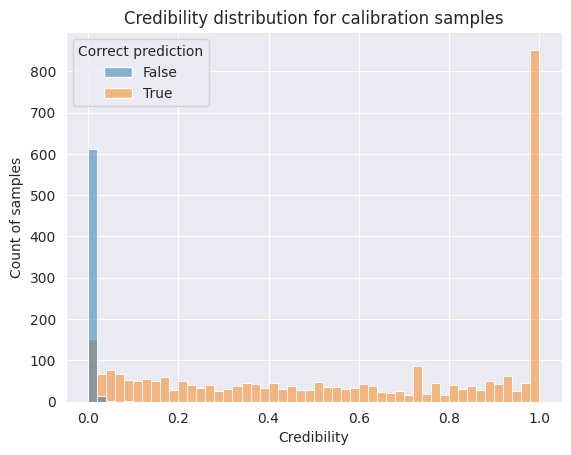

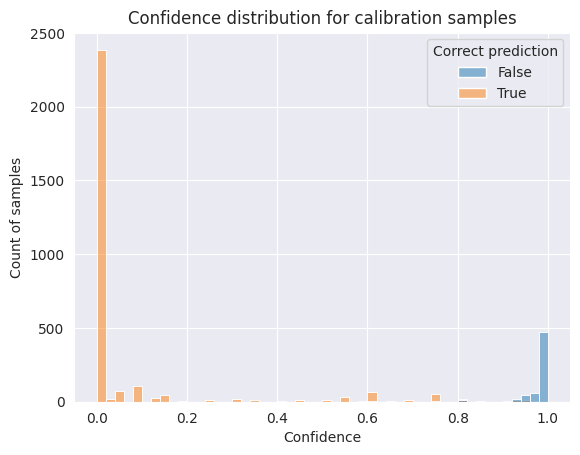

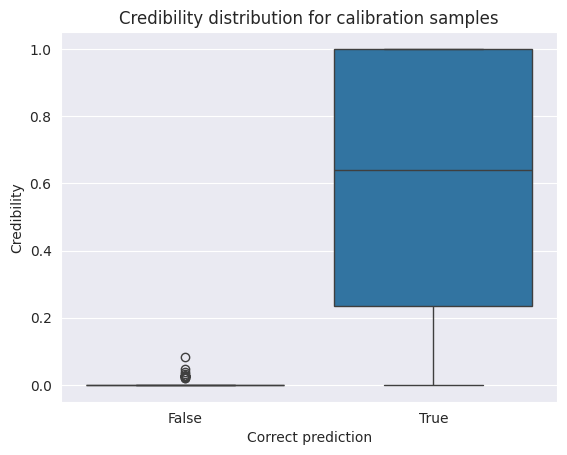

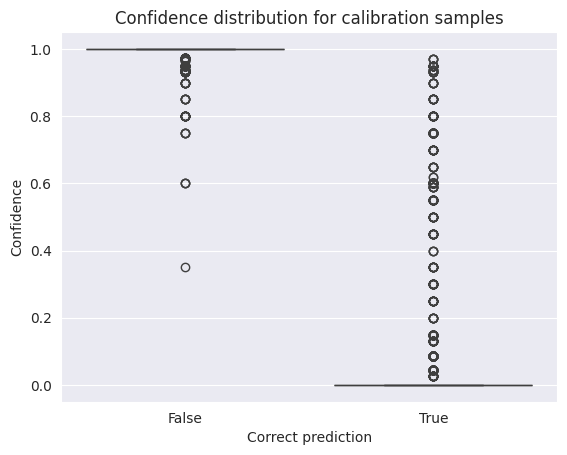

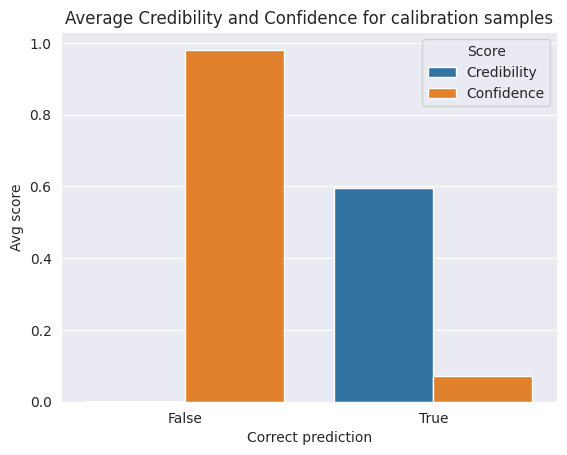

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

p_value_cal_dist = pd.DataFrame({"cal_cred": cal_results["cred_p_val_cal"],
                                 "cal_conf": cal_results["conf_p_val_cal"],
                                 "Correct prediction": y_cal == y_cal_predict})

plt.figure()
plt.title("Credibility distribution for calibration samples")
sns.histplot(p_value_cal_dist, x="cal_cred", hue="Correct prediction", bins=50)
plt.xlabel("Credibility")
plt.ylabel("Count of samples")
# plt.axvline(x=0.05, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
plt.show()

plt.figure()
plt.title("Confidence distribution for calibration samples")
sns.histplot(p_value_cal_dist, x="cal_conf", hue="Correct prediction", bins=50)
plt.xlabel("Confidence")
plt.ylabel("Count of samples")
plt.show()

# avg_cred_correct = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == True])
# avg_cred_incorrect = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == False])
# 
# print(avg_cred_correct, avg_cred_incorrect)
plt.figure()
plt.title("Credibility distribution for calibration samples")
sns.boxplot(p_value_cal_dist, y="cal_cred", x="Correct prediction", orient="v")
plt.ylabel("Credibility")
plt.show()

plt.figure()
plt.title("Confidence distribution for calibration samples")
sns.boxplot(p_value_cal_dist, y="cal_conf", x="Correct prediction", orient="v")
plt.ylabel("Confidence")
plt.show()

cal_cred_corr_avg = np.mean(p_value_cal_dist[p_value_cal_dist["Correct prediction"]]["cal_cred"])
cal_cred_incorr_avg = np.mean(p_value_cal_dist[~p_value_cal_dist["Correct prediction"]]["cal_cred"])

cal_conf_corr_avg = np.mean(p_value_cal_dist[p_value_cal_dist["Correct prediction"]]["cal_conf"])
cal_conf_incorr_avg = np.mean(p_value_cal_dist[~p_value_cal_dist["Correct prediction"]]["cal_conf"])

df_avg = pd.DataFrame({"avg": [cal_cred_corr_avg, cal_conf_corr_avg, cal_cred_incorr_avg, cal_conf_incorr_avg],
                       "Correct prediction": [True, True, False, False],
                       "Score": ["Credibility", "Confidence", "Credibility", "Confidence"]})


plt.figure()
plt.title("Average Credibility and Confidence for calibration samples")
sns.barplot(df_avg, x="Correct prediction", y="avg", hue="Score")
plt.ylabel("Avg score")
plt.show()

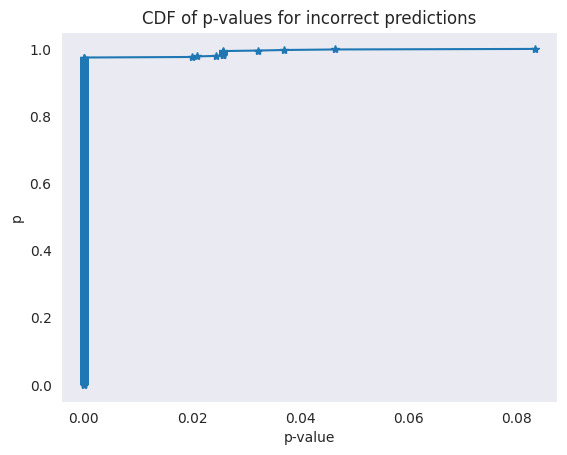

It's possible to see that there's a huge elbow after p-value 0. We could select this number as the threshold, but in concept drift detection applied to malware samples we rather prefer to detect false positives than false negatives. Using the classic threshold of 0.05, we can see that 99.84 % of incorrect choices have p-value < 0.05. This threshold has been considered acceptable for the problem, as it covers even more samples.


In [136]:
def compute_cdf(data):
    data_sorted = np.sort(data)
    p = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
    return data_sorted, p


cred_cdf = compute_cdf(list(p_value_cal_dist[~p_value_cal_dist["Correct prediction"]]["cal_cred"]))

threshold = 0.05
focus_p, focus_p_value = (cred_cdf[1][cred_cdf[0] < threshold],
                          cred_cdf[0][cred_cdf[0] < threshold])

elbow_p, elbow_p_value = (focus_p[len(focus_p) - 1],
                          focus_p_value[len(focus_p_value) - 1])

plt.figure()
plt.title("CDF of p-values for incorrect predictions")
plt.plot(cred_cdf[0], cred_cdf[1], marker="*")
plt.xlabel("p-value")
plt.ylabel("p")
plt.grid()
plt.show()

print("It's possible to see that there's a huge elbow after p-value 0. "
      "We could select this number as the threshold, but in concept drift detection applied to malware samples we rather prefer to detect false positives than false negatives. Using the classic threshold of 0.05, we can see that",
      f"{round(elbow_p * 100, 2)} % of incorrect choices have p-value < {threshold}. This threshold has been considered acceptable for the problem, as it covers even more samples."
      )

In [17]:
with open(
        "models/ice-10-malw-static-features/p_vals_ncms_full_train_rf_full_test_phase.p", "rb"
) as f:
    test_results = pickle.load(f)

In [18]:
model_name = "./models/ice-10-malw-static-features/rf_full_train_ice.p"
rf_full = data.load_cached_data(model_name)

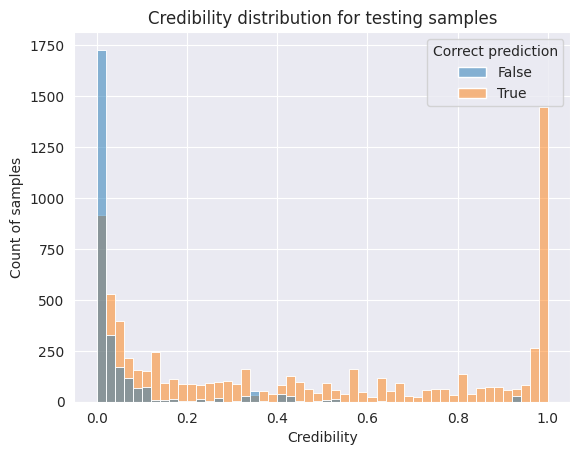

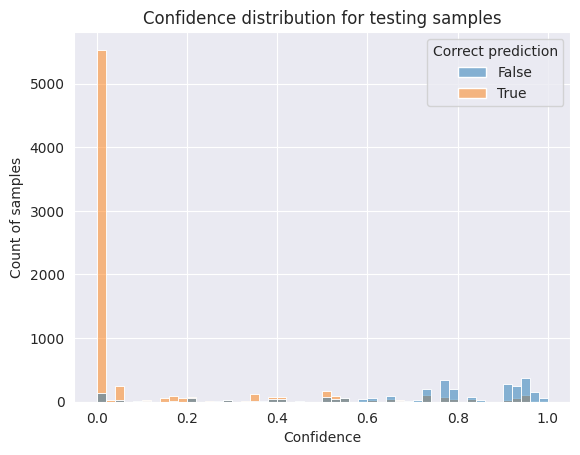

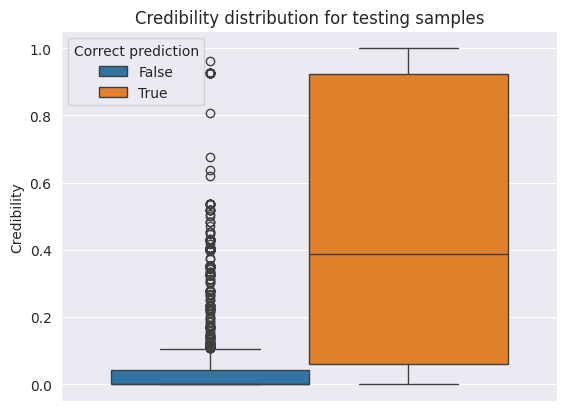

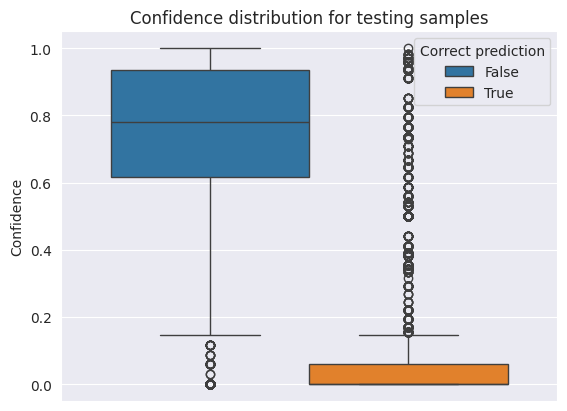

In [124]:
y_test_predict = rf_full.predict(X_test)

p_value_test_dist = pd.DataFrame({"test_cred": test_results["cred"],
                                  "test_conf": test_results["conf"],
                                  "family": y_test,
                                  "Correct prediction": y_test == y_test_predict})

plt.figure()
plt.title("Credibility distribution for testing samples")
sns.histplot(p_value_test_dist, x="test_cred", hue="Correct prediction", bins=50)
plt.xlabel("Credibility")
plt.ylabel("Count of samples")
plt.show()

plt.figure()
plt.title("Confidence distribution for testing samples")
sns.histplot(p_value_test_dist, x="test_conf", hue="Correct prediction", bins=50)
plt.xlabel("Confidence")
plt.ylabel("Count of samples")
plt.show()

# avg_cred_correct = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == True])
# avg_cred_incorrect = np.mean(p_value_cal_dist["cal_cred"][p_value_cal_dist["correct_pred"] == False])
# 
# print(avg_cred_correct, avg_cred_incorrect)
plt.figure()
plt.title("Credibility distribution for testing samples")
sns.boxplot(p_value_test_dist, y="test_cred", hue="Correct prediction", orient="v")
plt.legend(title="Correct prediction")
plt.ylabel("Credibility")
plt.show()

plt.figure()
plt.title("Confidence distribution for testing samples")
sns.boxplot(p_value_test_dist, y="test_conf", hue="Correct prediction", orient="v")
plt.legend(title="Correct prediction")
plt.ylabel("Confidence")
plt.show()

In [23]:
unique_drift_families, num_drifted_samples = (
    np.unique(list(p_value_test_dist[p_value_test_dist["test_cred"] < 0.05]["family"]), return_counts=True))

# plt.bar(unique_drift_families, num_drifted_samples)
print(f"A total of {sum(num_drifted_samples)} testing points are drifting "
      f"({round(sum(num_drifted_samples) / len(p_value_test_dist) * 100, 2)} % of testing points)")

A total of 3811 testing points are drifting (37.42 % of testing points)


In [24]:
from sklearn.metrics import accuracy_score

testing_acc = accuracy_score(y_test, y_test_predict)
print(f"Random Forest classifier has {round(testing_acc * 100, 2)} % accuracy over the testing set")

Random Forest classifier has 72.76 % accuracy over the testing set


In [26]:
df_drift = pd.DataFrame({"family": unique_drift_families,
                         "num_test_drifted": num_drifted_samples,
                         })
df_drift.set_index("family", inplace=True)

In [30]:
print(f"Drifted samples belongs to {df_drift.shape[0]} different families "
      f"({round(df_drift.shape[0] / len(np.unique(y_test)) * 100, 2)} % of the families present in the testing set)")

Drifted samples belongs to 180 different families (86.96 % of the families present in the testing set)


In [31]:
uniq_fam_test, count_test_fam = np.unique(y_test, return_counts=True)
df_uniq_fam_test = pd.DataFrame({"family": uniq_fam_test, "count": count_test_fam})
df_uniq_fam_test.set_index("family", inplace=True)

df_drift_cmp = df_drift.join(df_uniq_fam_test)

fam_with_complete_drift = df_drift_cmp[df_drift_cmp["num_test_drifted"] == df_drift_cmp["count"]]
print(f"A total of {fam_with_complete_drift.shape[0]} families have all drifting testing samples.")

A total of 5 families have all drifting testing samples.


In [32]:
label_mapping = {i: label for i, label in enumerate(all_labels)}

# Map the encoded values back to the original labels
drifted_families = [label_mapping[family_id] for family_id in fam_with_complete_drift.index]
fam_with_complete_drift.index = drifted_families

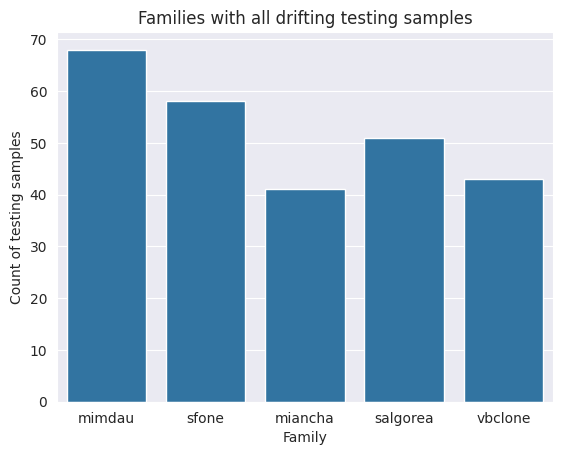

In [108]:
plt.figure()
plt.title("Families with all drifting testing samples")
sns.barplot(x=fam_with_complete_drift.index, y=fam_with_complete_drift["count"])
plt.xlabel("Family")
plt.ylabel("Count of testing samples")
plt.show()

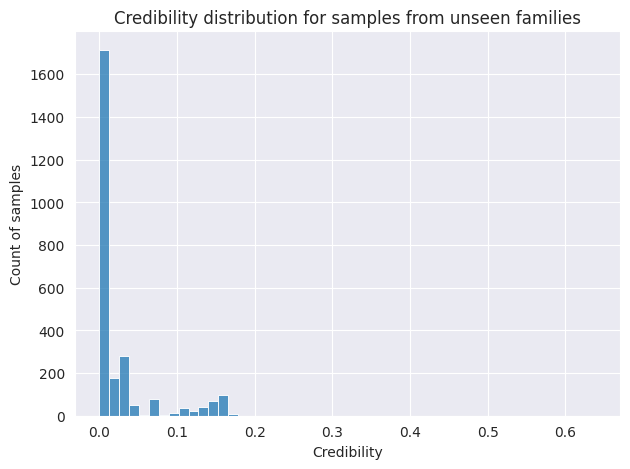

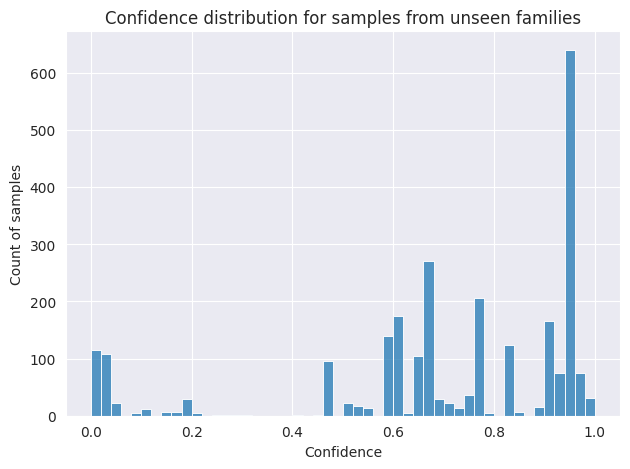

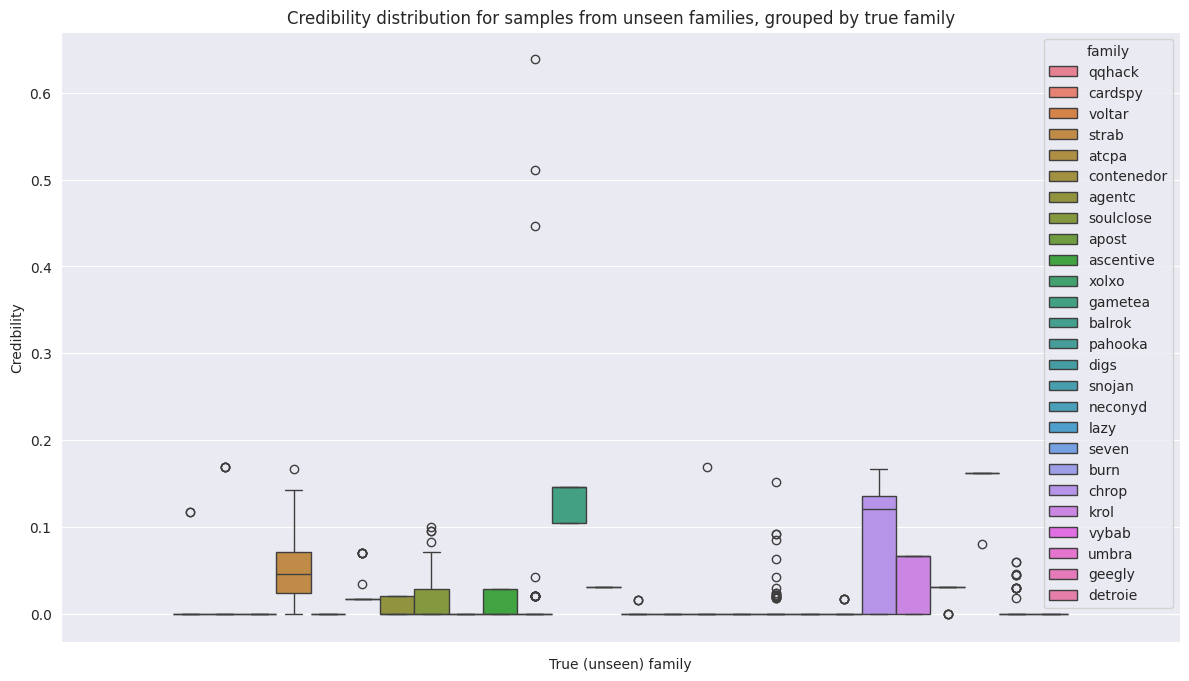

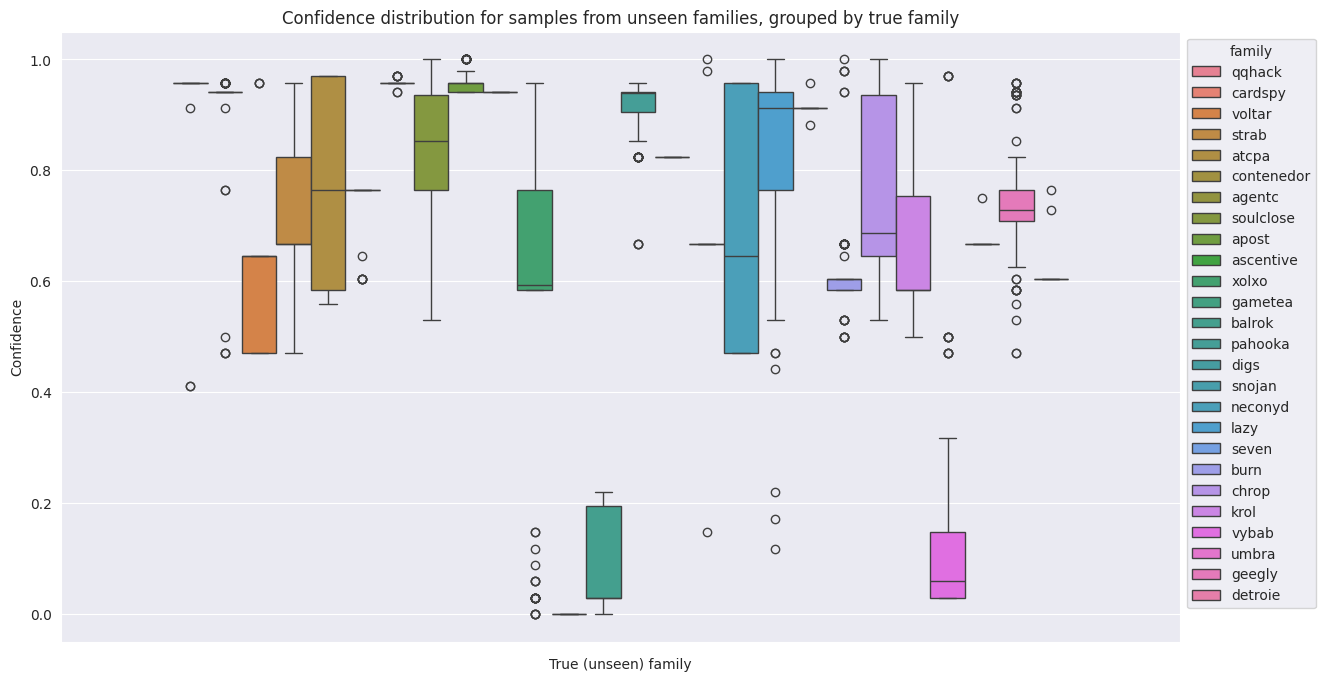

In [123]:
test_app_fam_results_name = "./models/ice-10-malw-static-features/p_vals_ncms_full_train_rf_test_phase_app_fam.p"
test_app_fam_results = data.load_cached_data(test_app_fam_results_name)

y_test_app_fam_pred_codes = rf_full.predict(X_test_new_fam)
y_test_app_fam_pred = pd.Categorical.from_codes(y_test_app_fam_pred_codes, categories=all_labels)

p_value_test_app_fam_dist = pd.DataFrame({"test_cred": test_app_fam_results["cred"],
                                          "test_conf": test_app_fam_results["conf"],
                                          "family":
                                              malware_dataset.testing_dataset[
                                                  malware_dataset.testing_dataset["family"].isin(
                                                      families_in_test_not_train)]["family"],
                                          "family_pred": y_test_app_fam_pred})

plt.title("Credibility distribution for samples from unseen families")
sns.histplot(p_value_test_app_fam_dist, x="test_cred", bins=50)
plt.tight_layout()
plt.xlabel("Credibility")
plt.ylabel("Count of samples")
plt.show()

plt.title("Confidence distribution for samples from unseen families")
sns.histplot(p_value_test_app_fam_dist, x="test_conf", bins=50)
plt.tight_layout()
plt.ylabel("Count of samples")
plt.xlabel("Confidence")
plt.show()

plt.figure(figsize=(12, 7))
plt.title("Credibility distribution for samples from unseen families, grouped by true family")
box = sns.boxplot(p_value_test_app_fam_dist, y="test_cred", hue="family", orient="v")
plt.xlabel("True (unseen) family")
plt.ylabel("Credibility")
plt.tight_layout()
sns.move_legend(box, "best", bbox_to_anchor=(1, 1))

plt.show()

plt.figure(figsize=(12, 7))
plt.title("Confidence distribution for samples from unseen families, grouped by true family")
box = sns.boxplot(p_value_test_app_fam_dist, y="test_conf", hue="family", orient="v")
plt.tight_layout()
plt.xlabel("True (unseen) family")
plt.ylabel("Confidence")
sns.move_legend(box, "best", bbox_to_anchor=(1, 1))
plt.show()

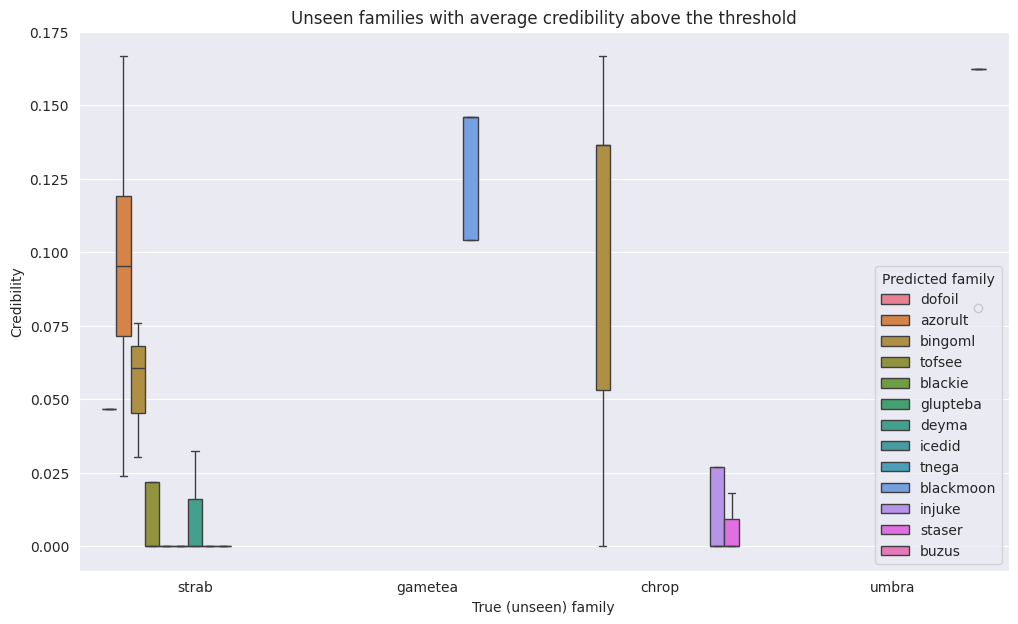

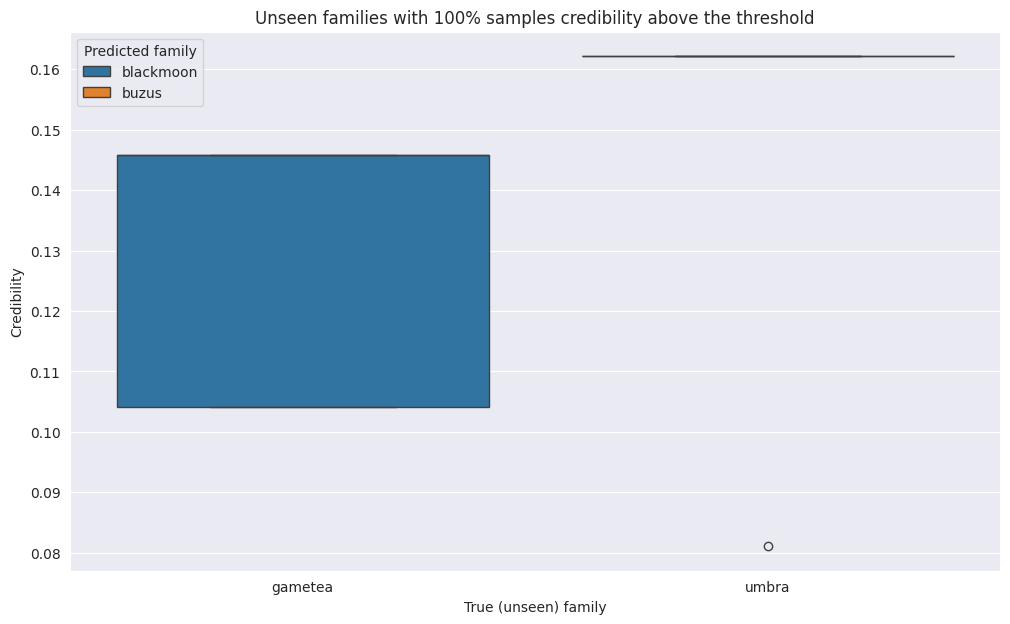

In [106]:
families_with_high_cred, families_with_all_high_cred = [], []
for family in families_in_test_not_train:

    df_sub = p_value_test_app_fam_dist[p_value_test_app_fam_dist["family"] == family]
    if np.mean(df_sub["test_cred"]) >= threshold:
        df_sub.loc[:,"family_pred"] = df_sub["family_pred"].astype(str).str.strip()
        families_with_high_cred.append(family)
    if (df_sub["test_cred"] >= threshold).all():
        families_with_all_high_cred.append(family)

plt.figure(figsize=(12, 7))
plt.title("Unseen families with average credibility above the threshold")
df_sub = p_value_test_app_fam_dist[p_value_test_app_fam_dist["family"].isin(families_with_high_cred)]

df_sub_new = df_sub.copy()
df_sub_new["family_pred"] = df_sub["family_pred"].astype(str).str.strip()

box = sns.boxplot(df_sub_new, x="family", y="test_cred", hue="family_pred", orient="v")
sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("True (unseen) family")
plt.ylabel("Credibility")
plt.legend(title="Predicted family")
plt.show()

plt.figure(figsize=(12, 7))
plt.title("Unseen families with 100% samples credibility above the threshold")
df_sub = p_value_test_app_fam_dist[p_value_test_app_fam_dist["family"].isin(families_with_all_high_cred)]

df_sub_new = df_sub.copy()
df_sub_new["family_pred"] = df_sub["family_pred"].astype(str).str.strip()

box = sns.boxplot(df_sub_new, x="family", y="test_cred", hue="family_pred", orient="v")
sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1))
plt.legend(title="Predicted family")
plt.xlabel("True (unseen) family")
plt.ylabel("Credibility")
plt.show()